In [4]:
import kagglehub
import os
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-23 20:58:53.923134: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 20:58:54.320804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 20:58:56.065653: I tensorflow/core/util/port.cc:153] oneDNN custom opera

In [5]:
# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /home/ao627515/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [6]:
!cp -r ~/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images ./datasets

In [7]:
def create_dataset(dossier_source, dossier_dest, test_size=0.2, val_size=0.1):
    """
    Crée un dataset structuré en train / val / test à partir d'un dossier source.

    Args:
        dossier_source (str): chemin vers le dossier contenant les sous-dossiers par classe
        dossier_dest (str): chemin vers le dossier de destination
        test_size (float): proportion d'images pour le test
        val_size (float): proportion d'images pour la validation (sur le train)

    Returns:
        dict: dictionnaire contenant les chemins et statistiques
    """
    # Création des dossiers principaux train, val et test
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(dossier_dest, split), exist_ok=True)

    # Liste des classes (sous-dossiers)
    classes = [
        d
        for d in os.listdir(dossier_source)
        if os.path.isdir(os.path.join(dossier_source, d))
    ]

    stats = {"total": 0, "train": 0, "val": 0, "test": 0, "classes": {}, "paths": {}}

    for classe in classes:
        print(f"Traitement de la classe: {classe}")

        chemin_classe = os.path.join(dossier_source, classe)
        images = [
            f
            for f in os.listdir(chemin_classe)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        # Split train+val et test
        train_val_imgs, test_imgs = train_test_split(
            images, test_size=test_size, random_state=42
        )
        # Split train et val
        train_imgs, val_imgs = train_test_split(
            train_val_imgs, test_size=val_size, random_state=42
        )

        # Création des sous-dossiers pour chaque split
        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(dossier_dest, split, classe), exist_ok=True)

        # Copie des images
        for img in train_imgs:
            shutil.copy2(
                os.path.join(chemin_classe, img),
                os.path.join(dossier_dest, "train", classe, img),
            )
        for img in val_imgs:
            shutil.copy2(
                os.path.join(chemin_classe, img),
                os.path.join(dossier_dest, "val", classe, img),
            )
        for img in test_imgs:
            shutil.copy2(
                os.path.join(chemin_classe, img),
                os.path.join(dossier_dest, "test", classe, img),
            )

        # Mise à jour des stats
        stats["total"] += len(images)
        stats["train"] += len(train_imgs)
        stats["val"] += len(val_imgs)
        stats["test"] += len(test_imgs)
        stats["classes"][classe] = {
            "total": len(images),
            "train": len(train_imgs),
            "val": len(val_imgs),
            "test": len(test_imgs),
        }

        print(
            f"  Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}"
        )

    # Ajout des chemins vers chaque split
    stats["paths"] = {
        "train": os.path.join(dossier_dest, "train"),
        "val": os.path.join(dossier_dest, "val"),
        "test": os.path.join(dossier_dest, "test"),
    }

    # Affichage des stats finales
    print(f"\n{'='*50}")
    print("STATISTIQUES DU DATASET")
    print(f"{'='*50}")
    print(f"Images totales: {stats['total']}")
    print(f"Train: {stats['train']} ({stats['train']/stats['total']*100:.1f}%)")
    print(f"Val: {stats['val']} ({stats['val']/stats['total']*100:.1f}%)")
    print(f"Test: {stats['test']} ({stats['test']/stats['total']*100:.1f}%)")
    print(f"\nDétail par classe:")
    for classe, data in stats["classes"].items():
        print(
            f"  {classe}: {data['total']} (train: {data['train']}, val: {data['val']}, test: {data['test']})"
        )
    print(f"{'='*50}\n")

    return stats

In [8]:
dataset_paths = create_dataset("./datasets/cell_images", "./datasets/malaria_dataset", test_size=0.2, val_size=0.1)

train_dataset = dataset_paths["paths"]["train"]
val_dataset = dataset_paths["paths"]["val"]
test_dataset = dataset_paths["paths"]["test"]
print(train_dataset)
print(val_dataset)
print(test_dataset)

Traitement de la classe: Parasitized
  Train: 9920, Val: 1103, Test: 2756
Traitement de la classe: Uninfected
  Train: 9920, Val: 1103, Test: 2756

STATISTIQUES DU DATASET
Images totales: 27558
Train: 19840 (72.0%)
Val: 2206 (8.0%)
Test: 5512 (20.0%)

Détail par classe:
  Parasitized: 13779 (train: 9920, val: 1103, test: 2756)
  Uninfected: 13779 (train: 9920, val: 1103, test: 2756)

./datasets/malaria_dataset/train
./datasets/malaria_dataset/val
./datasets/malaria_dataset/test


In [9]:
def classify_cell_image_imagenet(image_path):
    """
    Teste DenseNet121 pré-entraîné sur ImageNet pour une image de cellule sanguine.
    Pas de fine-tuning, juste pour observer les prédictions brutes.

    Args:
        image_path (str): chemin vers l'image à classifier

    Returns:
        dict: top 5 prédictions ImageNet avec labels et probabilités
    """
    # Charger DenseNet121 pré-entraîné ImageNet
    model = models.densenet121(pretrained=True)
    model.eval()

    # Prétraitement standard ImageNet
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Charger l'image
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0)  # ajouter batch dimension

    # Prédiction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]

    # Charger les labels ImageNet
    import json, urllib.request

    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    with urllib.request.urlopen(url) as f:
        labels = json.load(f)

    # Top 5 prédictions
    top_idx = np.argsort(probs)[::-1][:5]
    top_labels = [labels[i] for i in top_idx]
    top_probs = probs[top_idx]

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img)
    axes[0].set_title("Image de la cellule")
    axes[0].axis("off")

    axes[1].barh(top_labels, top_probs * 100, color="skyblue")
    axes[1].set_xlabel("Confiance (%)")
    axes[1].set_title("Top 5 prédictions ImageNet")
    axes[1].invert_yaxis()
    for i, (label, score) in enumerate(zip(top_labels, top_probs * 100)):
        axes[1].text(score + 1, i, f"{score:.1f}%", va="center")

    plt.tight_layout()
    plt.show()

    # Affichage console
    print("\n=== Top 5 prédictions ===")
    for i, (label, score) in enumerate(zip(top_labels, top_probs), 1):
        print(f"{i}. {label}: {score*100:.2f}%")

    return {label: float(score) for label, score in zip(top_labels, top_probs)}

/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


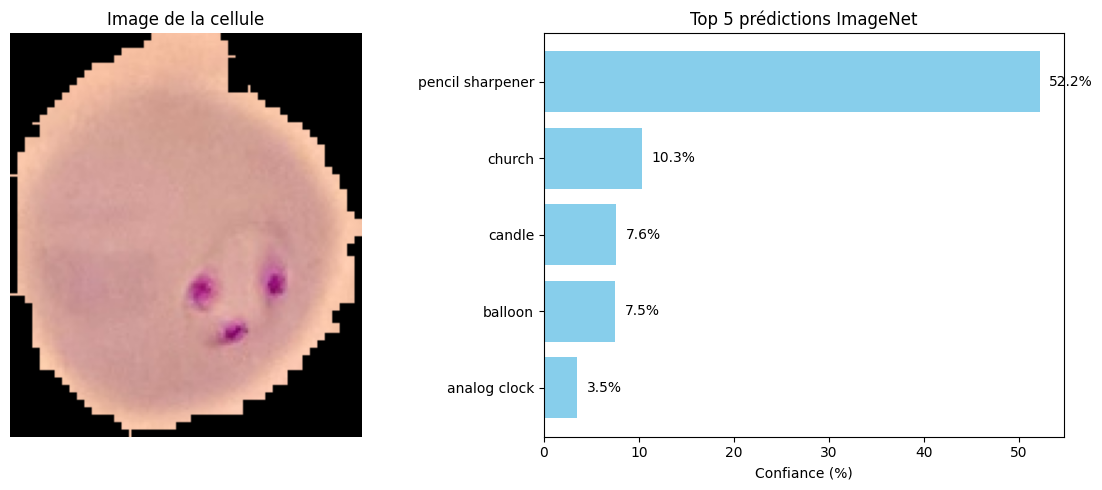


=== Top 5 prédictions ===
1. pencil sharpener: 52.19%
2. church: 10.30%
3. candle: 7.63%
4. balloon: 7.55%
5. analog clock: 3.52%


{'pencil sharpener': 0.5219147205352783,
 'church': 0.10304304957389832,
 'candle': 0.07626739144325256,
 'balloon': 0.07545299828052521,
 'analog clock': 0.03524068370461464}

In [10]:
classify_cell_image_imagenet("./datasets/malaria_dataset/test/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png")

In [11]:
def create_densenet121_model(num_classes, img_size=224):
    """
    Crée un modèle de classification d'images avec DenseNet121 et transfer learning.

    Args:
        num_classes (int): nombre de classes à prédire
        img_size (int): taille des images d'entrée (img_size x img_size)

    Returns:
        keras.Model: modèle prêt à être compilé et entraîné
    """

    # Base DenseNet121 pré-entraînée sur ImageNet
    base_model = DenseNet121(
        input_shape=(img_size, img_size, 3),
        include_top=False,  # Supprime la couche de sortie originale
        weights="imagenet",  # Utilise les poids pré-entraînés sur ImageNet
    )

    # Geler les couches de base pour ne pas les entraîner au début
    base_model.trainable = False

    # Ajouter des couches personnalisées pour notre tâche
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Réduit chaque feature map à une moyenne
    x = Dense(128, activation="relu")(x)  # Couche fully connected
    x = Dropout(0.5)(x)  # Régularisation pour éviter l'overfitting
    predictions = Dense(num_classes, activation="softmax")(x)  # Couche de sortie

    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [12]:
# model = create_densenet121_model(num_classes=2)

In [13]:
def train_densenet121_model(
    train_dataset,
    val_dataset,
    test_dataset,
    num_classes,
    epochs=10,
    learning_rate=0.0001,
    img_size=224,
    batch_size=32,
):
    """
    Entraîne un modèle DenseNet121 pour détecter les cellules infectées par le paludisme.
    Les datasets sont des chemins vers des dossiers contenant les sous-dossiers des classes.

    Args:
        train_dataset (str): chemin vers le dossier train
        val_dataset (str): chemin vers le dossier validation
        test_dataset (str): chemin vers le dossier test
        num_classes (int): nombre de classes (ex: 2 pour infected/uninfected)
        epochs (int): nombre d’époques d’entraînement
        learning_rate (float): taux d’apprentissage
        img_size (int): taille des images (img_size x img_size)
        batch_size (int): taille des batches

    Returns:
        model: modèle entraîné
        history: historique de l’entraînement
    """

    # --- 1. Générateurs d'images ---
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode="nearest",
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    val_gen = val_test_datagen.flow_from_directory(
        val_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    test_gen = val_test_datagen.flow_from_directory(
        test_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    # --- 2. Créer le modèle DenseNet121 ---
    model = create_densenet121_model(num_classes=num_classes, img_size=img_size)

    # --- 3. Compiler le modèle ---
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # --- 4. Callbacks ---
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        ),
        ModelCheckpoint(
            "exports/models/best_densenet121_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1,
        ),
    ]

    # --- 5. Entraînement ---
    print("\n🚀 Début de l'entraînement sur DenseNet121...\n")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # --- 6. Évaluation sur le test set ---
    print("\n🔍 Évaluation sur le jeu de test :")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"✅ Précision sur le test set : {test_acc*100:.2f}%")

    # --- 7. Sauvegarde du modèle final ---
    model.save("exports/models/densenet121_malaria_classifier.keras")
    print("\n💾 Modèle final sauvegardé : densenet121_malaria_classifier.keras")

    # --- 8. Visualisation de l'entraînement ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(history.history["accuracy"], label="Entraînement")
    axes[0].plot(history.history["val_accuracy"], label="Validation")
    axes[0].set_title("Évolution de la précision")
    axes[0].set_xlabel("Époque")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history.history["loss"], label="Entraînement")
    axes[1].plot(history.history["val_loss"], label="Validation")
    axes[1].set_title("Évolution de la perte")
    axes[1].set_xlabel("Époque")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, history, train_gen.class_indices

Found 19840 images belonging to 2 classes.
Found 2206 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


2025-10-23 20:59:13.935203: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



🚀 Début de l'entraînement sur DenseNet121...



/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7036 - loss: 0.6014
Epoch 1: val_accuracy improved from None to 0.89846, saving model to exports/models/best_densenet121_model.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 1582s 3s/step - accuracy: 0.7964 - loss: 0.4475 - val_accuracy: 0.8985 - val_loss: 0.2807
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8794 - loss: 0.3113
Epoch 2: val_accuracy did not improve from 0.89846
620/620 ━━━━━━━━━━━━━━━━━━━━ 1490s 2s/step - accuracy: 0.8855 - loss: 0.2999 - val_accuracy: 0.8908 - val_loss: 0.2620
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8895 - loss: 0.2881
Epoch 3: val_accuracy improved from 0.89846 to 0.90707, saving model to exports/models/best_densenet121_model.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 1483s 2s/step - accuracy: 0.8940 - loss: 0.2796 - val_accuracy: 0.9071 - val_loss: 0.2335
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9019 - loss: 0.2608
Epoch 4: val_accuracy i

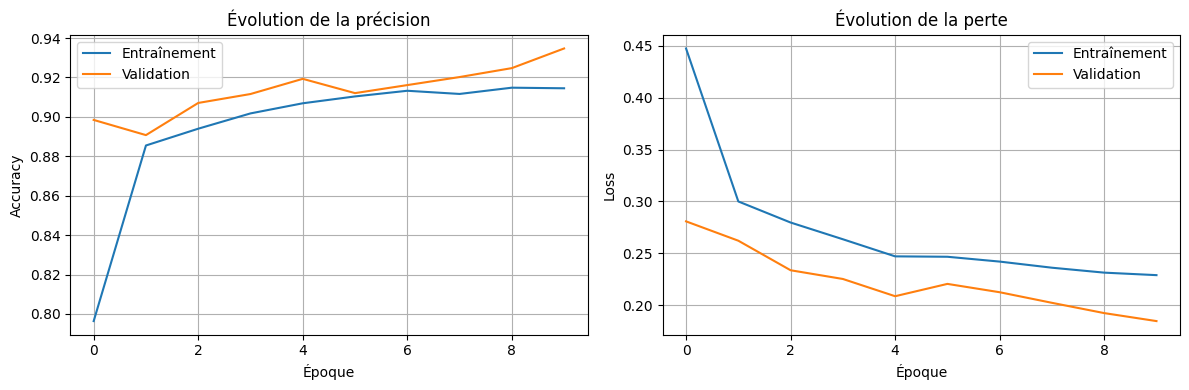

In [14]:
model, history, class_indices = train_densenet121_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    num_classes=2,
    epochs=10,
    learning_rate=0.0001,
)

In [20]:
class MalariaCellClassifier:
    """Classificateur de cellules sanguines pour détecter le paludisme"""

    def __init__(self, model_path, class_indices):
        """
        Args:
            model_path (str): chemin vers le modèle entraîné (.h5 ou .keras)
            class_indices (dict): dictionnaire {nom_classe: indice} retourné par ImageDataGenerator
        """
        # Charger le modèle
        self.model = load_model(model_path)

        # Inverser le dictionnaire pour récupérer le nom de la classe à partir de l'indice
        self.classes = {v: k for k, v in class_indices.items()}

    def predict_cell(self, image_path):
        """Prédit la classe d'une cellule sur une image"""
        # Charger l'image et redimensionner à 224x224
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisation

        # Obtenir les probabilités
        predictions = self.model.predict(img_array, verbose=0)
        class_idx = np.argmax(predictions[0])
        confidence = predictions[0][class_idx]
        class_name = self.classes[class_idx]

        return class_name, confidence, predictions[0]

    def predict_and_display(self, image_path):
        """Affiche l'image et les probabilités par classe"""
        class_name, confidence, all_probs = self.predict_cell(image_path)

        # Préparer la figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Image originale
        img = image.load_img(image_path)
        axes[0].imshow(img)
        axes[0].set_title(f"Prédiction: {class_name}\nConfiance: {confidence*100:.1f}%")
        axes[0].axis("off")

        # Histogramme des probabilités
        class_names = [self.classes[i] for i in range(len(all_probs))]
        probs = all_probs * 100  # Convertir en %
        colors = [
            "green" if i == np.argmax(all_probs) else "skyblue"
            for i in range(len(probs))
        ]

        axes[1].barh(class_names, probs, color=colors)
        axes[1].set_xlabel("Probabilité (%)")
        axes[1].set_title("Confiance par classe")
        for i, (name, prob) in enumerate(zip(class_names, probs)):
            axes[1].text(prob + 1, i, f"{prob:.1f}%", va="center")

        plt.tight_layout()
        plt.show()

        # Affichage console
        print(f"\n=== RÉSULTAT ===")
        print(f"Classe prédite: {class_name}")
        print(f"Confiance: {confidence*100:.2f}%")

        return class_name, confidence

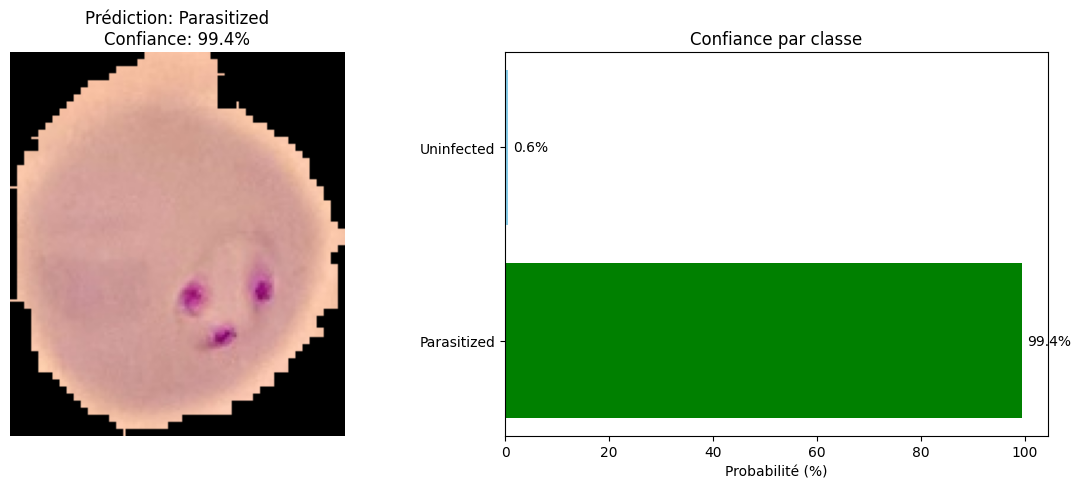


=== RÉSULTAT ===
Classe prédite: Parasitized
Confiance: 99.45%


In [25]:
classifier = MalariaCellClassifier(
    model_path="exports/models/densenet121_malaria_classifier.keras",
    class_indices=class_indices,
)

class_name, confidence = classifier.predict_and_display(
    "./datasets/malaria_dataset/test/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png"
)

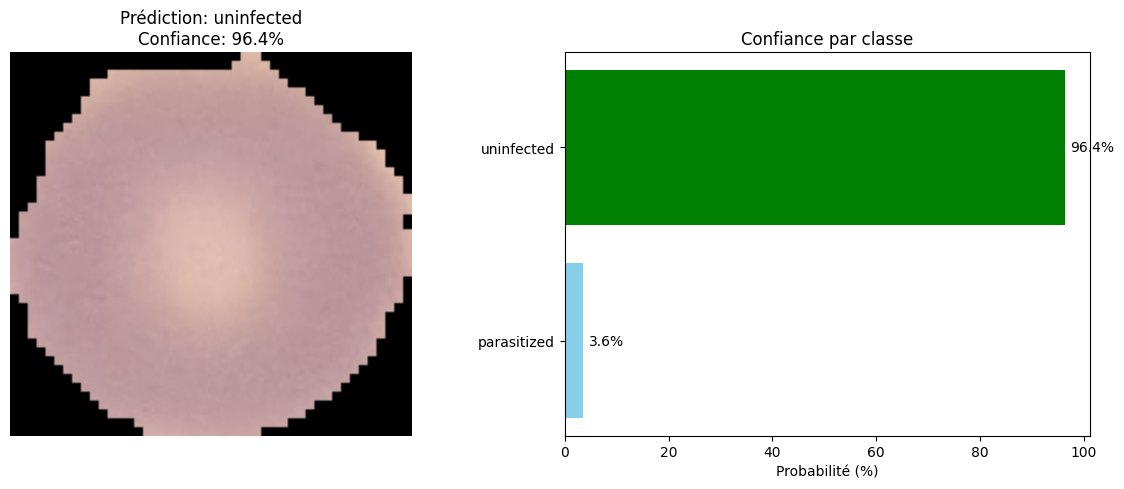


=== RÉSULTAT ===
Classe prédite: uninfected
Confiance: 96.43%


In [22]:
class_name, confidence = classifier.predict_and_display(
    "./datasets/malaria_dataset/test/Uninfected/C1_thinF_IMG_20150604_104722_cell_191.png"
)

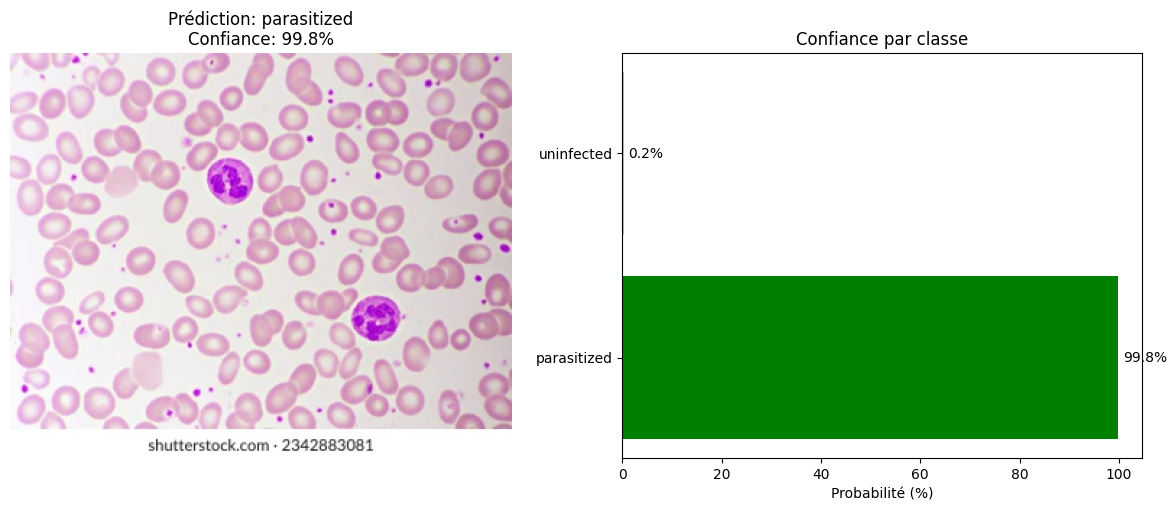


=== RÉSULTAT ===
Classe prédite: parasitized
Confiance: 99.75%


In [24]:
class_name, confidence = classifier.predict_and_display(
    "./assets/imgs/unknown_cells/frotti_1.webp"
)

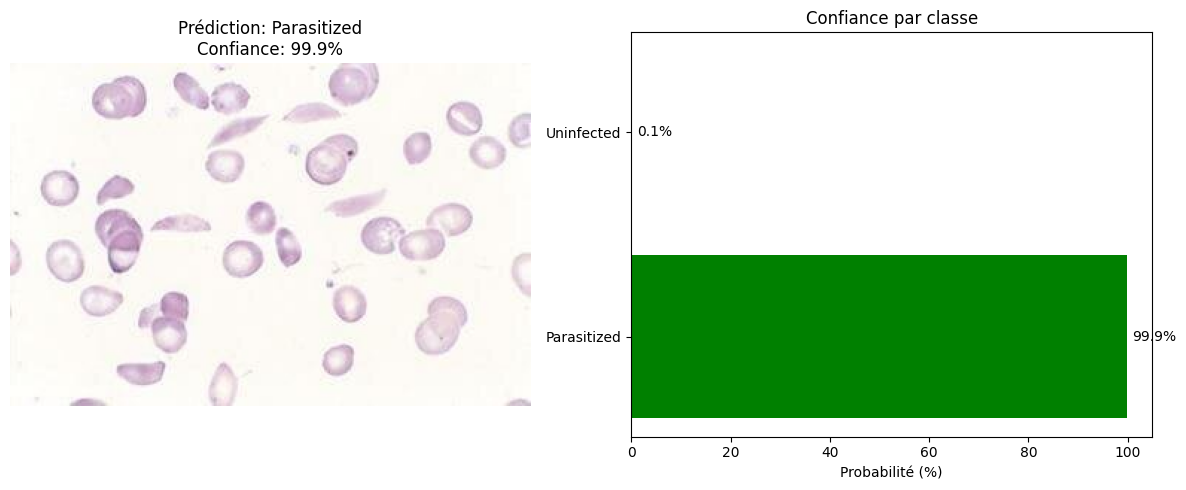


=== RÉSULTAT ===
Classe prédite: Parasitized
Confiance: 99.90%


In [26]:
class_name, confidence = classifier.predict_and_display(
    "./assets/imgs/unknown_cells/frotti_2.png"
)

# Fine-tuning du modèle

Pour améliorer les performances du modèle, nous allons :
1. Dégeler progressivement les couches du DenseNet121
2. Utiliser un learning rate plus faible pour le fine-tuning
3. Réentraîner le modèle avec ces nouveaux paramètres

Cette approche permet d'ajuster les poids pré-entraînés de manière plus fine pour notre tâche spécifique.

In [27]:
def create_densenet121_model_for_finetuning(num_classes, img_size=224, fine_tune_layers=0):
    """
    Crée un modèle DenseNet121 avec possibilité de fine-tuning sur les dernières couches.
    
    Args:
        num_classes (int): nombre de classes à prédire
        img_size (int): taille des images d'entrée
        fine_tune_layers (int): nombre de blocs denses à dégeler pour le fine-tuning
                               (0: aucun, 1-4: débloque les n derniers blocs)
    
    Returns:
        model: modèle configuré pour le fine-tuning
    """
    # Charger DenseNet121 pré-entraîné
    base_model = DenseNet121(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Par défaut, geler toutes les couches
    base_model.trainable = True
    for layer in base_model.layers:
        layer.trainable = False
        
    # Dégeler les n derniers blocs denses si demandé
    if fine_tune_layers > 0:
        # DenseNet121 a 4 blocs denses
        dense_blocks = [
            'conv5_block16_2_conv',  # Début du dernier bloc
            'conv4_block24_2_conv',  # Début de l'avant-dernier bloc
            'conv3_block12_2_conv',  # Début du 2ème bloc
            'conv2_block6_2_conv',   # Début du 1er bloc
        ]
        
        # Dégeler à partir de la couche spécifiée
        if fine_tune_layers <= len(dense_blocks):
            unfreeze_from = dense_blocks[fine_tune_layers - 1]
            print(f"Dégel des couches à partir de: {unfreeze_from}")
            
            found_layer = False
            for layer in base_model.layers:
                if layer.name == unfreeze_from:
                    found_layer = True
                if found_layer:
                    layer.trainable = True
    
    # Ajouter les couches de classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Afficher un résumé des couches entraînables/non-entraînables
    trainable_count = sum([layer.trainable for layer in model.layers])
    total_count = len(model.layers)
    print(f"\nCouches entraînables: {trainable_count}/{total_count}")
    
    return model

In [28]:
def run_finetuning(
    train_dataset,
    val_dataset,
    test_dataset,
    num_classes=2,
    img_size=224,
    batch_size=32,
    epochs=20,
    learning_rate=1e-5,
    fine_tune_layers=2,
    model_path_save='exports/models/best_densenet121_finetuned_model.keras',
    final_model_save='exports/models/densenet121_malaria_classifier_finetuned.keras'
):
    """
    Configure et lance le fine-tuning de DenseNet121.

    Retourne : (model_ft, history_ft, test_acc_ft, class_indices)
    """
    # --- 1. Générateurs d'images ---
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode="nearest",
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    val_gen = val_test_datagen.flow_from_directory(
        val_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    test_gen = val_test_datagen.flow_from_directory(
        test_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    # --- 2. Créer le modèle DenseNet121 pour fine-tuning ---
    model_ft = create_densenet121_model_for_finetuning(
        num_classes=num_classes, img_size=img_size, fine_tune_layers=fine_tune_layers
    )

    # --- 3. Compiler ---
    model_ft.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # --- 4. Callbacks ---
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
        ModelCheckpoint(model_path_save, monitor="val_accuracy", save_best_only=True, verbose=1),
    ]

    # --- 5. Entraînement ---
    print("\n🚀 Début du fine-tuning sur DenseNet121...\n")
    history_ft = model_ft.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # --- 6. Évaluation sur le test set ---
    print("\n🔍 Évaluation du modèle fine-tuné sur le jeu de test :")
    test_loss_ft, test_acc_ft = model_ft.evaluate(test_gen)
    print(f"✅ Précision sur le test set : {test_acc_ft*100:.2f}%")

    # --- 7. Sauvegarde du modèle final ---
    try:
        model_ft.save(final_model_save)
        print(f"\n💾 Modèle final sauvegardé : {final_model_save}")
    except Exception as e:
        print(f"Impossible de sauvegarder le modèle final : {e}")

    # --- 8. Visualisation de l'entraînement ---
    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy
        axes[0].plot(history_ft.history["accuracy"], label="Entraînement")
        axes[0].plot(history_ft.history["val_accuracy"], label="Validation")
        axes[0].set_title("Évolution de la précision (Fine-tuning)")
        axes[0].set_xlabel("Époque")
        axes[0].set_ylabel("Accuracy")
        axes[0].legend()
        axes[0].grid(True)

        # Loss
        axes[1].plot(history_ft.history["loss"], label="Entraînement")
        axes[1].plot(history_ft.history["val_loss"], label="Validation")
        axes[1].set_title("Évolution de la perte (Fine-tuning)")
        axes[1].set_xlabel("Époque")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Impossible d'afficher les graphiques : {e}")

    return model_ft, history_ft, test_acc_ft, train_gen.class_indices

In [29]:
# Appel simplifié : définir les paramètres et lancer le fine-tuning
fine_tuning_params = {
    'epochs': 20,
    'learning_rate': 1e-5,
    'fine_tune_layers': 2,
    'batch_size': 32,
    'img_size': 224,
    'num_classes': 2,
}

model_ft, history_ft, test_acc_ft, ft_class_indices = run_finetuning(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    num_classes=fine_tuning_params['num_classes'],
    img_size=fine_tuning_params['img_size'],
    batch_size=fine_tuning_params['batch_size'],
    epochs=fine_tuning_params['epochs'],
    learning_rate=fine_tuning_params['learning_rate'],
    fine_tune_layers=fine_tuning_params['fine_tune_layers'],
)

# Si vous voulez réutiliser le class_indices pour l'inférence plus tard :
class_indices = ft_class_indices

print(f"Fine-tuning terminé — précision test : {test_acc_ft*100:.2f}%")

Found 19840 images belonging to 2 classes.
Found 2206 images belonging to 2 classes.
Found 2206 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Dégel des couches à partir de: conv4_block24_2_conv

Couches entraînables: 126/433

🚀 Début du fine-tuning sur DenseNet121...

Dégel des couches à partir de: conv4_block24_2_conv

Couches entraînables: 126/433

🚀 Début du fine-tuning sur DenseNet121...

Epoch 1/20
Epoch 1/20
 39/620 ━━━━━━━━━━━━━━━━━━━━ 24:02 2s/step - accuracy: 0.5031 - loss: 0.8934

KeyboardInterrupt: 